## Предсказываем ЗП соискателя по резюме (база резюме hh.ru)

Данильченко Вадим

In [1]:
import numpy as np #Библиотека работы с массивами
import pandas as pd # Библиотека для работы с базами

from tensorflow.keras.models import Sequential, Model # 
from tensorflow.keras.layers import Concatenate, Input, Dense, Dropout, BatchNormalization, Flatten #
from tensorflow.keras import utils #Используем для to_categoricall
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop #
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence #
from tensorflow.keras.preprocessing.sequence import pad_sequences #
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки

from sklearn.preprocessing import StandardScaler # 
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error #
#from google.colab import files #Для загрузки своей картинки

import random #Для генерации случайных чисел 
import math # Для округления
#import os #Для работы с файлами 
import re #
import matplotlib.pyplot as plt #
%matplotlib inline

from IPython.display import clear_output

from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive # Подключаем диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
fixed_df = pd.read_csv('drive/My Drive/data/hh_fixed.csv')
print(fixed_df.shape)
fixed_df.head()

(62967, 13)


,Unnamed: 0,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано
1,1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано
2,2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано
3,3,"Мужчина , 33 года , родился 2 августа 1985",180000 руб.,Руководитель IT отдела,"Москва , м. Щукинская , не готов к переезду ,...","частичная занятость, полная занятость","удаленная работа, полный день",Опыт работы 15 лет 10 месяцев Руководитель IT...,"""Ай-Теко"", ведущий российский системный интегр...",Старший системный администратор,Руководитель IT отдела 180 000 руб. Информацио...,09.04.2019 14:39,Имеется собственный автомобиль
4,4,"Мужчина , 22 года , родился 1 сентября 1996",40000 руб.,Junior Developer,"Москва , м. Юго-Западная , не готов к переезд...","стажировка, частичная занятость, проектная работа","гибкий график, удаленная работа",Опыт работы 1 год 1 месяц Junior Developer 40...,R-Style SoftLab,Менеджер IT-проектов,Junior Developer 40 000 руб. Информационные те...,29.03.2019 12:40,Не указано


In [4]:
fixed_df.tail()

,Unnamed: 0,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
62962,62962,"Мужчина , 31 год , родился 11 октября 1987",80000 руб.,Программист PHP (full-stack) (удаленно),"Москва , м. Белорусская , не готов к переезду...","частичная занятость, проектная работа, полная ...",удаленная работа,Опыт работы 5 лет 9 месяцев Программист PHP (...,Индивидуальное предпринимательство / частная п...,фриланс,Программист PHP (full-stack) (удаленно) 80 000...,12.03.2019 06:43,Не указано
62963,62963,"Мужчина , 41 год , родился 13 декабря 1977",50000 руб.,начальник отдела автоматизированных систем упр...,"Киров , не готов к переезду , готов к командир...",полная занятость,полный день,Опыт работы 15 лет 9 месяцев Октябрь 2012 — п...,МРСК Центра и Приволжья,зам. руководителя группы АСУ,Высшее образование 2010 Вятский Государственны...,09.05.2019 11:51,Не указано
62964,62964,"Мужчина , 26 лет , родился 2 сентября 1992",60000 руб.,Специалист по информационной безопасности,"Москва , готов к переезду , готов к командировкам",полная занятость,полный день,Опыт работы 6 лет 8 месяцев Специалист по инф...,"АО ""Восточное оборонное предприятие ""Гранит""",Инженер по противодействию иностранным техниче...,Высшее образование 2014 Владивостокский госуд...,26.04.2019 12:47,Не указано
62965,62965,"Мужчина , 35 лет , родился 23 июля 1983",190000 руб.,Frontend-разработчик,"Москва , готов к переезду (Санкт-Петербург, Уф...","частичная занятость, полная занятость","гибкий график, полный день, сменный график, ва...",Опыт работы 15 лет 6 месяцев Frontend-разрабо...,Softailor,Инженер-конструктор,Frontend-разработчик 190 000 руб. Информационн...,15.03.2019 09:50,Не указано
62966,62966,"Мужчина , 35 лет , родился 22 сентября 1983",35000 руб.,Монтажник слаботочных систем,"Самара , не готов к переезду , готов к команди...",полная занятость,полный день,Опыт работы 3 месяца Монтажник слаботочных си...,смт-интех,Монтажник слаботочных систем,Образование Среднее специальное образование,27.04.2019 10:08,Не указано


In [5]:
fixed_df.iloc[10:100]

,Unnamed: 0,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
10,10,"Мужчина , 61 год , родился 16 февраля 1958",2000 EUR,Программист,"Москва , не готов к переезду , не готов к кома...",полная занятость,полный день,Опыт работы 27 лет 4 месяца Программист 2 000...,Консалтинг КАС,Главный аналитик,Высшее образование (Кандидат наук) 1980 РПИ (Р...,07.06.2018 09:41,Не указано
11,11,"Мужчина , 49 лет , родился 7 февраля 1970",60000 руб.,Системный инженер,"Москва , м. Маяковская , не готов к переезду ...",полная занятость,полный день,Опыт работы 26 лет 5 месяцев Март 2019 — по н...,Управление Федеральной службы по надзору в сфе...,Ведущий специалист-эксперт,Высшее образование 1993 Московский инженерно-...,21.04.2019 20:49,Имеется собственный автомобиль
12,12,"Мужчина , 54 года , родился 27 июня 1964",180000 руб.,Ведущий разработчик ORACLE,"Москва , м. Бульвар Рокоссовского , не готов ...",полная занятость,"гибкий график, полный день, удаленная работа",Опыт работы 30 лет 9 месяцев Ведущий разработ...,Государственная корпорация “Банк развития и в...,Бизнес-аналитик / Разработчик ПО,Высшее образование 1987 Московский авиационны...,10.08.2018 12:00,Не указано
13,13,"Мужчина , 25 лет , родился 28 июня 1993",50000 руб.,Специалист по ИТ,"Москва , готов к переезду , готов к командировкам","частичная занятость, полная занятость","полный день, сменный график",Опыт работы 7 лет 3 месяца Специалист по ИТ 5...,ТОРИС,"Ремонт и продажа (Mac, iPhone, iPad)",Неоконченное высшее образование 2016 CUJAE Ing...,08.08.2018 00:41,Не указано
14,14,"Мужчина , 27 лет , родился 7 июля 1991",40000 руб.,Инженер,"Сочи , не готов к переезду , готов к редким ко...",полная занятость,"полный день, сменный график",Опыт работы 6 лет 10 месяцев Июль 2018 — по н...,Федеральное агенство связи. Российские сети ве...,Старший инженер,Высшее образование 2016 Ростовский государств...,21.04.2019 20:39,Не указано
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,"Женщина , 19 лет , родилась 31 декабря 1999",23000 руб.,Специалист по работе с клиентами,"Челябинск , не готова к переезду , не готова к...",полная занятость,полный день,Опыт работы 6 месяцев Ноябрь 2018 — Январь 2...,Chico's,Администратор салона красоты,Образование Среднее образование,20.04.2019 12:20,Не указано
96,96,"Мужчина , 54 года , родился 27 ноября 1964",80000 руб.,"Программист 1С, Автосалон, Отель","Сочи , готов к переезду (Москва, Санкт-Петербу...","частичная занятость, проектная работа","гибкий график, удаленная работа",Опыт работы 8 лет 9 месяцев Февраль 2017 — по...,ИП Русанов,Учредитель,Высшее образование 2002 Ижевский государствен...,12.04.2019 18:59,Имеется собственный автомобиль
97,97,"Мужчина , 38 лет , родился 16 сентября 1980",46000 руб.,"старший/ведущий инженер, начальник/зам. началь...","Пермь , готов к переезду (Санкт-Петербург, Рес...","частичная занятость, полная занятость","гибкий график, полный день",Опыт работы 13 лет 9 месяцев Сентябрь 2013 — ...,"ПАО ""МТС""",Ведущий инженер,Высшее образование 2005 Пермский Государственн...,07.05.2019 14:40,Имеется собственный автомобиль
98,98,"Мужчина , 34 года , родился 2 января 1985",55000 руб.,Тестировщик / QA,"Москва , готов к переезду (Другие страны) , го...","частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, уд...",Опыт работы 8 лет 10 месяцев Январь 2019 — по...,CreaGames,Тестировщик,Неоконченное высшее образование 2006 Юридичес...,15.04.2019 14:47,Не указано


In [6]:
# вытащим пол
def check_gender(text):
  gender = text.split(',')[0].strip()
  if gender=='Мужчина':
    return 1
  elif gender=='Женщина':
    return 0
  else:
    return 2


fixed_df['gender'] = fixed_df['Пол, возраст'].apply(check_gender).astype('category')
fixed_df['gender'].value_counts()

1    51084
0    11883
Name: gender, dtype: int64

In [7]:
# вытащим возраст
def check_age(text):
  age = re.sub('[^\d]', '', text.split(',')[1].strip().lower())
  return age


fixed_df['age'] = fixed_df['Пол, возраст'].apply(check_age).astype('int')
fixed_df['age'].value_counts()

30     3861
29     3796
28     3716
31     3630
27     3539
       ... 
72        3
100       2
77        1
119       1
76        1
Name: age, Length: 64, dtype: int64

In [8]:
# посмотрим на распределение возраста
fixed_df['age'].describe()

count    62967.000000
mean        32.230788
std          8.125252
min         14.000000
25%         26.000000
50%         31.000000
75%         36.000000
max        119.000000
Name: age, dtype: float64

In [9]:
# посмотрим на распределение возраста выше 99 процентиля (выбросы)
fixed_df[fixed_df['age']>np.percentile(fixed_df['age'], 99)]['age'].describe()

count    602.000000
mean      61.495017
std        4.701840
min       58.000000
25%       59.000000
50%       60.000000
75%       63.000000
max      119.000000
Name: age, dtype: float64

In [10]:
# уберем все записи, выше 99 процентиля (выбросы)
fixed_df = fixed_df[fixed_df['age']<=np.percentile(fixed_df['age'], 99)]
fixed_df['age'].describe()

count    62365.000000
mean        31.948304
std          7.622164
min         14.000000
25%         26.000000
50%         31.000000
75%         36.000000
max         57.000000
Name: age, dtype: float64

In [11]:
# разобьем возраст на группы:
# больше 5 в группу х5, меньше 5 в группу х0
# т.е. 27=25 (группа [25-30)), а 23=20 (группа [20-25))
def age_to_cat(age):
  age = str(age)
  if int(age[1])>=5:
    return age[0]+'5'
  else:
    return age[0]+'0'

fixed_df['age_cat'] = fixed_df['age'].apply(age_to_cat).astype('category')
fixed_df['age_cat'].value_counts()

25    17383
30    16486
35     9211
20     8920
40     4956
45     2814
50     1453
55      572
15      562
10        8
Name: age_cat, dtype: int64

In [12]:
# вытащим город
def check_city(text):
  city = text.split(',')[0].strip()
  return city
fixed_df['city'] = fixed_df['Город'].apply(check_city)
fixed_df['city'].value_counts()

Москва                                23473
Санкт-Петербург                        6587
Краснодар                              1477
Новосибирск                            1286
Казань                                 1228
                                      ...  
Павловская Слобода                        1
Нижняя Тура                               1
Сумы                                      1
Фершампенуаз (Челябинская область)        1
Барда (Пермский край)                     1
Name: city, Length: 1027, dtype: int64

In [13]:
# разнесем города по группам: Москва | Спб | Миллионник | Другое
millionCities = "Новосибирск Екатеринбург Нижний Новгород Казань Челябинск Омск Самара Ростов-на-Дону Уфа Красноярск Пермь Воронеж Волгоград"
def city_to_cat(text):
  if text == 'Москва':
    return 'Москва'
  elif text == 'Санкт-Петербург':
    return 'СПб'
  elif text in millionCities.split(' '):
    return 'Миллионник'
  else:
    return 'Другой_город'

fixed_df['city_cat'] = fixed_df['city'].apply(city_to_cat).astype('category')
fixed_df['city_cat'].value_counts()

Москва          23473
Другой_город    23007
Миллионник       9298
СПб              6587
Name: city_cat, dtype: int64

In [14]:
# вытащим готовность к командировкам
# 1 - готов /0 - не готов / 2 - другое (не заполнено)
def check_business_trip(text):
  elements = text.split(',')
  flag = 2
  for elem in elements:
    if 'не готов к командировкам' in elem:
      flag = 0
      break
    elif 'готов к командировкам' in elem or 'готов к редким командировкам' in elem:
      flag = 1
      break
  return flag

fixed_df['business_trip'] = fixed_df['Город'].apply(check_business_trip).astype('category')
fixed_df['business_trip'].value_counts()

1    35836
0    14589
2    11940
Name: business_trip, dtype: int64

In [15]:
# вытащим готовность к переезду
# 1 - готов /0 - не готов / 2 - другое (не заполнено)
def check_moving(text):
  elements = text.split(',')
  flag = 2
  for elem in elements:
    if 'не готов к переезду' in elem:
      flag = 0
      break
    elif 'готов к переезду' in elem:
      flag = 1
      break
  return flag

fixed_df['moving'] = fixed_df['Город'].apply(check_moving).astype('category')
fixed_df['moving'].value_counts()

0    31557
1    18006
2    12802
Name: moving, dtype: int64

In [16]:
# вытащим зарплату, конвертируем в рубли 
def check_salary(text):
  text = text.lower()
  num = int(re.sub('[^\d]', '', text))
  if 'usd' in text:
      num = float(num)*65
  elif 'kzt' in text:
      num = float(num)*0.17
  elif 'грн' in text:
      num = float(num)*2.6
  elif 'белруб' in text:
      num = float(num)*30.5
  elif 'eur' in text:
      num = float(num)*70
  elif 'kgs' in text:
      num = float(num)*0.9
  elif 'сум' in text:
      num = float(num)*0.007
  elif 'azn' in text:
      num = float(num)*37.5
  elif 'руб' in text:
      num = float(num)
  else:
      num = 0
  return num

fixed_df['salary'] = fixed_df['ЗП'].apply(check_salary)
fixed_df['salary'].value_counts()

50000.0     5713
40000.0     5310
30000.0     4766
60000.0     4263
80000.0     3220
            ... 
77777.0        1
161500.0       1
24375.0        1
475000.0       1
262143.0       1
Name: salary, Length: 636, dtype: int64

In [17]:
# посмотрим Занятость
fixed_df['Занятость'].value_counts()

полная занятость                                                                     41920
частичная занятость, полная занятость                                                 6659
частичная занятость, проектная работа, полная занятость                               5601
проектная работа, полная занятость                                                    1338
стажировка, частичная занятость, проектная работа, полная занятость                   1269
проектная работа, частичная занятость, полная занятость                                969
частичная занятость                                                                    957
стажировка, частичная занятость, полная занятость                                      836
частичная занятость, проектная работа                                                  720
стажировка, полная занятость                                                           628
стажировка, волонтерство, частичная занятость, проектная работа, полная занятость      372

In [18]:
# вытащим уникальные элементы
elements = []
for elem in fixed_df['Занятость'].value_counts().to_dict().keys():
  variants = elem.split(',')
  for variant in variants:
    variant = variant.strip()
    if variant not in elements:
      elements.append(variant)

elements

['полная занятость',
 'частичная занятость',
 'проектная работа',
 'стажировка',
 'волонтерство']

In [19]:
# разметим для каждой записи в стиле one hot encoding
fixed_df[elements] = 0

for i in range(fixed_df.shape[0]):
  for variant in fixed_df['Занятость'].iloc[i].split(','):
    variant = variant.strip()
    fixed_df[variant].loc[i] = 1

fixed_df.head()

,Unnamed: 0,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто,gender,age,age_cat,city,city_cat,business_trip,moving,salary,полная занятость,частичная занятость,проектная работа,стажировка,волонтерство
0,0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано,1,29,25,Новороссийск,Другой_город,0,1,40000.0,1,0,0,0,0
1,1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано,1,38,35,Новосибирск,Миллионник,1,0,40000.0,1,0,0,0,0
2,2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано,1,35,35,Москва,Москва,1,1,300000.0,1,0,0,0,0
3,3,"Мужчина , 33 года , родился 2 августа 1985",180000 руб.,Руководитель IT отдела,"Москва , м. Щукинская , не готов к переезду ,...","частичная занятость, полная занятость","удаленная работа, полный день",Опыт работы 15 лет 10 месяцев Руководитель IT...,"""Ай-Теко"", ведущий российский системный интегр...",Старший системный администратор,Руководитель IT отдела 180 000 руб. Информацио...,09.04.2019 14:39,Имеется собственный автомобиль,1,33,30,Москва,Москва,1,0,180000.0,1,1,0,0,0
4,4,"Мужчина , 22 года , родился 1 сентября 1996",40000 руб.,Junior Developer,"Москва , м. Юго-Западная , не готов к переезд...","стажировка, частичная занятость, проектная работа","гибкий график, удаленная работа",Опыт работы 1 год 1 месяц Junior Developer 40...,R-Style SoftLab,Менеджер IT-проектов,Junior Developer 40 000 руб. Информационные те...,29.03.2019 12:40,Не указано,1,22,20,Москва,Москва,1,0,40000.0,0,1,1,1,0


In [20]:
# посмотрим График
fixed_df['График'].value_counts()

полный день                                                                     31749
гибкий график, полный день, сменный график, удаленная работа                     5688
гибкий график, полный день, удаленная работа                                     3748
гибкий график, полный день, сменный график                                       3069
полный день, сменный график                                                      2484
полный день, удаленная работа                                                    2307
гибкий график, полный день, сменный график, вахтовый метод, удаленная работа     2145
гибкий график, полный день                                                       2017
удаленная работа                                                                 1609
гибкий график, удаленная работа                                                  1010
удаленная работа, гибкий график, полный день, сменный график                      957
удаленная работа, гибкий график, полный день          

In [21]:
# вытащим уникальные элементы из График
elements = []
for elem in fixed_df['График'].value_counts().to_dict().keys():
  variants = elem.split(',')
  for variant in variants:
    variant = variant.strip()
    if variant not in elements:
      elements.append(variant)

elements

['полный день',
 'гибкий график',
 'сменный график',
 'удаленная работа',
 'вахтовый метод']

In [22]:
# разметим для каждой записи в стиле one hot encoding
fixed_df[elements] = 0

for i in range(fixed_df.shape[0]):
  for variant in fixed_df['График'].iloc[i].split(','):
    variant = variant.strip()
    fixed_df[variant].loc[i] = 1

fixed_df.head()

,Unnamed: 0,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто,gender,age,age_cat,city,city_cat,business_trip,moving,salary,полная занятость,частичная занятость,проектная работа,стажировка,волонтерство,полный день,гибкий график,сменный график,удаленная работа,вахтовый метод
0,0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано,1,29,25,Новороссийск,Другой_город,0,1,40000.0,1,0,0,0,0,1,0,0,0,0
1,1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано,1,38,35,Новосибирск,Миллионник,1,0,40000.0,1,0,0,0,0,1,0,0,0,0
2,2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано,1,35,35,Москва,Москва,1,1,300000.0,1,0,0,0,0,1,0,0,0,0
3,3,"Мужчина , 33 года , родился 2 августа 1985",180000 руб.,Руководитель IT отдела,"Москва , м. Щукинская , не готов к переезду ,...","частичная занятость, полная занятость","удаленная работа, полный день",Опыт работы 15 лет 10 месяцев Руководитель IT...,"""Ай-Теко"", ведущий российский системный интегр...",Старший системный администратор,Руководитель IT отдела 180 000 руб. Информацио...,09.04.2019 14:39,Имеется собственный автомобиль,1,33,30,Москва,Москва,1,0,180000.0,1,1,0,0,0,1,0,0,1,0
4,4,"Мужчина , 22 года , родился 1 сентября 1996",40000 руб.,Junior Developer,"Москва , м. Юго-Западная , не готов к переезд...","стажировка, частичная занятость, проектная работа","гибкий график, удаленная работа",Опыт работы 1 год 1 месяц Junior Developer 40...,R-Style SoftLab,Менеджер IT-проектов,Junior Developer 40 000 руб. Информационные те...,29.03.2019 12:40,Не указано,1,22,20,Москва,Москва,1,0,40000.0,0,1,1,1,0,0,1,0,1,0


In [23]:
# вытащим опыт
def check_experience(text):
  text = str(text)
  text = text[len('Опыт работы '):text.find('месяц')]
  if len(text)>0:
    text = re.findall('\d', text)
    if 'месяц' not in text:
      return int(text[0])*12
    else:
      return int(text[0])*12 + int(text[1])
  else:
    return 0

fixed_df['experience'] = fixed_df['Опыт (двойное нажатие для полной версии)'].apply(check_experience).astype('int')
fixed_df['experience'].value_counts()

12     24548
24      7338
72      4623
84      4535
60      4486
36      4387
96      4254
48      4207
108     3616
0        371
Name: experience, dtype: int64

In [24]:
# исключим 0 (NaN)
fixed_df = fixed_df[fixed_df['experience']!=0]
fixed_df.head()

,Unnamed: 0,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто,gender,age,age_cat,city,city_cat,business_trip,moving,salary,полная занятость,частичная занятость,проектная работа,стажировка,волонтерство,полный день,гибкий график,сменный график,удаленная работа,вахтовый метод,experience
0,0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано,1,29,25,Новороссийск,Другой_город,0,1,40000.0,1,0,0,0,0,1,0,0,0,0,36
1,1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано,1,38,35,Новосибирск,Миллионник,1,0,40000.0,1,0,0,0,0,1,0,0,0,0,12
2,2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано,1,35,35,Москва,Москва,1,1,300000.0,1,0,0,0,0,1,0,0,0,0,12
3,3,"Мужчина , 33 года , родился 2 августа 1985",180000 руб.,Руководитель IT отдела,"Москва , м. Щукинская , не готов к переезду ,...","частичная занятость, полная занятость","удаленная работа, полный день",Опыт работы 15 лет 10 месяцев Руководитель IT...,"""Ай-Теко"", ведущий российский системный интегр...",Старший системный администратор,Руководитель IT отдела 180 000 руб. Информацио...,09.04.2019 14:39,Имеется собственный автомобиль,1,33,30,Москва,Москва,1,0,180000.0,1,1,0,0,0,1,0,0,1,0,12
4,4,"Мужчина , 22 года , родился 1 сентября 1996",40000 руб.,Junior Developer,"Москва , м. Юго-Западная , не готов к переезд...","стажировка, частичная занятость, проектная работа","гибкий график, удаленная работа",Опыт работы 1 год 1 месяц Junior Developer 40...,R-Style SoftLab,Менеджер IT-проектов,Junior Developer 40 000 руб. Информационные те...,29.03.2019 12:40,Не указано,1,22,20,Москва,Москва,1,0,40000.0,0,1,1,1,0,0,1,0,1,0,12


In [25]:
# сделаем группы по опыту:
# 0-3 | 3-6 | 6-12 | 12-24 | 24-36 | 36-60 | 60-120 | >120
def exp_to_cat(exp):
  if exp>=0 and exp<3:
    return '0-3'
  elif exp>=3 and exp<6:
    return '3-6'
  elif exp>=6 and exp<9:
    return '6-9'
  elif exp>=9 and exp<12:
    return '9-12'
  elif exp>=12 and exp<24:
    return '12-24'
  elif exp>=24 and exp<36:
    return '24-36'
  elif exp>=36 and exp<60:
    return '36-60'
  elif exp>=120:
    return '>120'

fixed_df['exp_cat'] = fixed_df['experience'].apply(exp_to_cat).astype('category')
fixed_df['exp_cat'].value_counts()

12-24    24548
36-60     8594
24-36     7338
Name: exp_cat, dtype: int64

In [26]:
# вытащим образование из Образование и ВУЗ
def check_education(text):
  digits_tmp = [i for i in re.finditer('\d', text)]
  if len(digits_tmp):
    return text[:digits_tmp[0].span()[0]]
  else:
    return ''

fixed_df['education'] = fixed_df['Образование и ВУЗ'].apply(check_education)
education_list = fixed_df[fixed_df['education'].str.contains('образов')]['education'].unique().tolist()
fixed_df['education'] = fixed_df['education'].apply(lambda x: x if x in education_list else 'other')
fixed_df['education'].value_counts()


Высшее образование                     37059
Среднее специальное образование         7560
Неоконченное высшее образование         5888
other                                   4750
Высшее образование (Бакалавр)           3350
Высшее образование (Магистр)            2282
Среднее образование                      722
Высшее образование (Кандидат наук)       375
Высшее образование (Доктор наук)           8
Name: education, dtype: int64

In [27]:
fixed_df['education'].iloc[0]

'Высшее образование '

In [28]:
# преобразуем категориальные переменные в формат one hot encoding: gender	age	city	business_trip	moving	salary	experience
X = pd.get_dummies(fixed_df[['gender', 'age_cat', 'city_cat', 'business_trip', 'moving', 'exp_cat', 'education']])
print(X.shape)
X.head()

(61994, 34)


,gender_0,gender_1,age_cat_10,age_cat_15,age_cat_20,age_cat_25,age_cat_30,age_cat_35,age_cat_40,age_cat_45,age_cat_50,age_cat_55,city_cat_Другой_город,city_cat_Миллионник,city_cat_Москва,city_cat_СПб,business_trip_0,business_trip_1,business_trip_2,moving_0,moving_1,moving_2,exp_cat_12-24,exp_cat_24-36,exp_cat_36-60,education_other,education_Высшее образование,education_Высшее образование (Бакалавр),education_Высшее образование (Доктор наук),education_Высшее образование (Кандидат наук),education_Высшее образование (Магистр),education_Неоконченное высшее образование,education_Среднее образование,education_Среднее специальное образование
0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [29]:
# добавим: полная занятость	частичная занятость	проектная работа	стажировка	волонтерство	полный день	гибкий график	сменный график	удаленная работа	вахтовый метод
X = pd.concat([X, fixed_df[['полная занятость',	'частичная занятость',	'проектная работа',	'стажировка',	'волонтерство',	'полный день',	'гибкий график',	'сменный график',	'удаленная работа',	'вахтовый метод']]], axis=1)
print(X.shape)
X.head()

(61994, 44)


,gender_0,gender_1,age_cat_10,age_cat_15,age_cat_20,age_cat_25,age_cat_30,age_cat_35,age_cat_40,age_cat_45,age_cat_50,age_cat_55,city_cat_Другой_город,city_cat_Миллионник,city_cat_Москва,city_cat_СПб,business_trip_0,business_trip_1,business_trip_2,moving_0,moving_1,moving_2,exp_cat_12-24,exp_cat_24-36,exp_cat_36-60,education_other,education_Высшее образование,education_Высшее образование (Бакалавр),education_Высшее образование (Доктор наук),education_Высшее образование (Кандидат наук),education_Высшее образование (Магистр),education_Неоконченное высшее образование,education_Среднее образование,education_Среднее специальное образование,полная занятость,частичная занятость,проектная работа,стажировка,волонтерство,полный день,гибкий график,сменный график,удаленная работа,вахтовый метод
0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0
4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,1,0


In [30]:
y = fixed_df['salary']
print(y.shape)
y.head()

(61994,)


0     40000.0
1     40000.0
2    300000.0
3    180000.0
4     40000.0
Name: salary, dtype: float64

In [31]:
# В качестве нормализации данных используем готовую библиотеку 
yScaler = StandardScaler()

# Скармливаем объекту двумерный вектор
yScaler.fit(np.asarray(y).reshape(-1, 1))

# Нормализуем по нормальному распределению
yTrainScaled = yScaler.transform(np.asarray(y).reshape(-1, 1))

print(yTrainScaled.shape)
print(np.asarray(y)[1])
print(yTrainScaled[1])

(61994, 1)
40000.0
[-0.30157778]


Epoch 1/30
106/106 [==============================] - 1s 5ms/step - loss: 1.4474 - mae: 0.5871 - val_loss: 0.2887 - val_mae: 0.3817
Epoch 2/30
106/106 [==============================] - 0s 3ms/step - loss: 1.2343 - mae: 0.4765 - val_loss: 0.2665 - val_mae: 0.3560
Epoch 3/30
106/106 [==============================] - 0s 3ms/step - loss: 1.1614 - mae: 0.4299 - val_loss: 0.2519 - val_mae: 0.3466
Epoch 4/30
106/106 [==============================] - 0s 3ms/step - loss: 1.1210 - mae: 0.4044 - val_loss: 0.2410 - val_mae: 0.3390
Epoch 5/30
106/106 [==============================] - 0s 3ms/step - loss: 1.0947 - mae: 0.3852 - val_loss: 0.2328 - val_mae: 0.3328
Epoch 6/30
106/106 [==============================] - 0s 3ms/step - loss: 1.0803 - mae: 0.3732 - val_loss: 0.2264 - val_mae: 0.3296
Epoch 7/30
106/106 [==============================] - 0s 3ms/step - loss: 1.0669 - mae: 0.3626 - val_loss: 0.2212 - val_mae: 0.3246
Epoch 8/30
106/106 [==============================] - 0s 3ms/step - loss: 1.

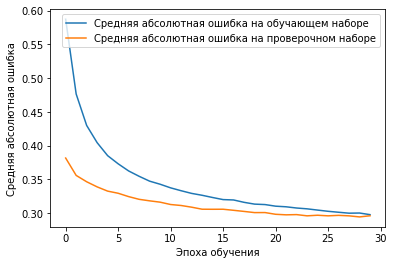

In [32]:
# создадим сетку по one hot encoding

input_1 = Input(shape=(X.shape[1],))
x1 = BatchNormalization()(input_1)
x1 = Dense(56, activation='relu', name='dense_1.1')(x1)
# x1 = Dense(128, activation='relu', name='dense_1.2')(x1)
x1 = Dropout(0.3)(x1)
x1 = Dense(28, activation='relu', name='dense_1.3')(x1)
output_1 = Dense(1, activation='linear', name='output_1')(x1)

model = Model(input_1, output_1)

model.compile(optimizer=Adam(1e-4),
              loss='mse',
              metrics=['mae'])

history = model.fit(np.asarray(X),
          yTrainScaled,
          epochs=30,
          validation_split=0.1,
          batch_size=528,
          verbose=1,
          shuffle=True)

plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [33]:
# Делаем предсказание и приводим его к начальному виду
pred = model.predict(np.asarray(X))
predUnscaled = yScaler.inverse_transform(pred).flatten()

# Среднее значение ошибки 
delta = predUnscaled - np.asarray(y)
absDelta = abs(delta)
print(sum(absDelta) / len(absDelta))

35399.23567748744


In [34]:
n = 10
for i in range(n):
  print('Реальное значение - ',np.asarray(y)[i], " Предсказанное значение - ", predUnscaled[i], " Разница - ", abs(np.asarray(y)[i]-predUnscaled[i]))

Реальное значение -  40000.0  Предсказанное значение -  44937.19  Разница -  4937.19140625
Реальное значение -  40000.0  Предсказанное значение -  60475.59  Разница -  20475.58984375
Реальное значение -  300000.0  Предсказанное значение -  176871.84  Разница -  123128.15625
Реальное значение -  180000.0  Предсказанное значение -  157667.12  Разница -  22332.875
Реальное значение -  40000.0  Предсказанное значение -  88182.61  Разница -  48182.609375
Реальное значение -  200000.0  Предсказанное значение -  165763.94  Разница -  34236.0625
Реальное значение -  120000.0  Предсказанное значение -  161686.58  Разница -  41686.578125
Реальное значение -  50000.0  Предсказанное значение -  58494.5  Разница -  8494.5
Реальное значение -  60000.0  Предсказанное значение -  102945.03  Разница -  42945.03125
Реальное значение -  70000.0  Предсказанное значение -  107395.39  Разница -  37395.390625


### большая ошибка. добавим описание желаемой позиции

In [35]:
!pip install pymorphy2
from pymorphy2 import MorphAnalyzer

In [36]:
# подготовим word2vec для должности
morph = MorphAnalyzer()

# токенизируем и приведем к начальной форме
def preprocess(text):
  sequence = re.findall('[\d\w]{1,}', str(text).lower().replace('ё', 'е'))
  # sequence = text_to_word_sequence(text, filters="!»#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n’", split=' ', lower=True)
  tmp_sequences = []
  for word in sequence:
    tmp_sequences.append(morph.parse(str(word))[0].normal_form)
  return tmp_sequences

sequences = []
for sequence in fixed_df['Ищет работу на должность:'].tolist():
  sequences.append(preprocess(sequence))

wvec = Word2Vec(sequences, size=100, window=3, min_count=1)

In [37]:
# создадим словарь
index2word = {k+1:v for k,v in enumerate(list(wvec.wv.vocab.keys()))}
index2word[0] = 'UNK'
word2index = {v:k for k,v in index2word.items()}

In [38]:
# переведем должности в индексы слов
sequences_ids = [[] for _ in sequences]
for i in range(len(sequences)):
  sequence = sequences[i]
  for word in sequence:
    if word in wvec:
      sequences_ids[i].append(word2index[word])
    else:
      sequences_ids[i].append(word2index['UNK'])

In [39]:
from collections import Counter

seq_length = []
for i in range(len(sequences_ids)):
  seq_length.append(len(sequences_ids[i]))


sorted(Counter(seq_length).items(), key=lambda kv: -kv[1])

[(2, 24009),
 (3, 12651),
 (4, 7854),
 (1, 6700),
 (5, 4075),
 (6, 2587),
 (7, 1605),
 (8, 1007),
 (9, 665),
 (10, 394),
 (11, 240),
 (12, 104),
 (13, 49),
 (14, 24),
 (0, 10),
 (15, 7),
 (16, 6),
 (17, 3),
 (19, 3),
 (18, 1)]

In [40]:
# выровняем до одной длины
seq_len = 6
sequences_pad = pad_sequences(sequences_ids, maxlen=seq_len)
sequences_pad[:2]

array([[ 3,  4,  5,  6,  7,  8],
       [ 0,  0,  0,  0,  9, 10]], dtype=int32)

In [41]:
# подготовим данные для сетки по названию вакансий

# создадим векторизатор word2vec
def vectorize(word):
  if word in wvec:
    return wvec.wv.__getitem__(word)
  else:
    return np.zeros(wvec.wv.vector_size)

# подготовим эмбеддинг
embed_matrix = np.zeros((len(wvec.wv.vocab.keys())+1, wvec.wv.vector_size))

for i in range(len(wvec.wv.vocab)):
  embed_matrix[i+1] = vectorize(list(wvec.wv.vocab.keys())[i])

In [42]:
from keras.layers import Embedding, SpatialDropout1D, Conv1D

In [43]:
# создадим сетку по Word2Vec

input_2 = Input(shape=(len(sequences_pad[0]),))

embedding_layer = Embedding(len(wvec.wv.vocab)+1,
                            wvec.wv.vector_size,
                            input_length=seq_len,
                            weights=[embed_matrix],
                            trainable=True
                            )(input_2)

# x2 = SpatialDropout1D(0.2)(embedding_layer)
# x2 = Dense(128, activation='relu', name='dense_2.1')(x2)
# x2 = Dense(96, activation='relu', name='dense_2.2')(x2)
# x2 = Dropout(0.2)(x2)

x3 = Conv1D(96, 5, padding='same', activation='relu')(embedding_layer)
x3 = Conv1D(128, 3, padding='same', activation='relu')(x3)
x3 = Conv1D(156, 1, padding='same', activation='relu')(x3)

x4 = Conv1D(72, 7, padding='same', activation='relu')(embedding_layer)
x4 = Conv1D(96, 5, padding='same', activation='relu')(x4)
x4 = Conv1D(128, 3, padding='same', activation='relu')(x4)

x5 = Concatenate()([x3, x4])
# x5 = Flatten()(x5)
# x5 = Dense(156, activation='relu', name='dense_2.3')(x5)
# x5 = Dropout(0.2)(x5)
# x5 = Dense(48, activation='relu', name='dense_2.4')(x5)


# x6 = Concatenate()([x2, x5])

x5 = Flatten()(x5)
output_2 = Dense(1, activation='linear', name='output_2')(x5)

model2 = Model(input_2, output_2)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 44)                176       
_________________________________________________________________
dense_1.1 (Dense)            (None, 56)                2520      
_________________________________________________________________
dropout (Dropout)            (None, 56)                0         
_________________________________________________________________
dense_1.3 (Dense)            (None, 28)                1596      
_________________________________________________________________
output_1 (Dense)             (None, 1)                 29        
Total params: 4,321
Trainable params: 4,233
Non-trainable params: 88
___________________________________________________

In [44]:
model2.compile(optimizer=Adam(1e-3),
              loss='mse',
              metrics=['mae'])

model2.fit(sequences_pad,
          yTrainScaled,
          epochs=20,
          validation_split=0.1,
          batch_size=512,
          verbose=1,
          shuffle=True)

Epoch 1/20
109/109 [==============================] - 1s 13ms/step - loss: 0.9837 - mae: 0.2812 - val_loss: 0.1607 - val_mae: 0.2588
Epoch 2/20
109/109 [==============================] - 1s 10ms/step - loss: 0.9571 - mae: 0.2610 - val_loss: 0.1620 - val_mae: 0.2671
Epoch 3/20
109/109 [==============================] - 1s 10ms/step - loss: 0.9416 - mae: 0.2585 - val_loss: 0.1493 - val_mae: 0.2524
Epoch 4/20
109/109 [==============================] - 1s 11ms/step - loss: 0.9321 - mae: 0.2555 - val_loss: 0.1578 - val_mae: 0.2567
Epoch 5/20
109/109 [==============================] - 1s 11ms/step - loss: 0.9379 - mae: 0.2614 - val_loss: 0.1525 - val_mae: 0.2597
Epoch 6/20
109/109 [==============================] - 1s 10ms/step - loss: 0.9173 - mae: 0.2550 - val_loss: 0.1544 - val_mae: 0.2589
Epoch 7/20
109/109 [==============================] - 1s 10ms/step - loss: 0.9413 - mae: 0.2511 - val_loss: 0.1588 - val_mae: 0.2646
Epoch 8/20
109/109 [==============================] - 1s 10ms/step - 

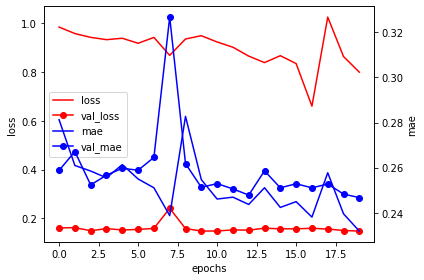

In [45]:
# посмотрим на историю обучения
r = model2.history
fig, ax1 = plt.subplots()

t = np.arange(0, len(r.history['mae']), 1)

ln1 = ax1.plot(t, r.history['loss'], color='r', label='loss')
ln2 = ax1.plot(t, r.history['val_loss'], color='r', marker='o', label='val_loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
# ax1.legend(loc=0)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ln3 = ax2.plot(t, r.history['mae'], color='b', label='mae')
ln4 = ax2.plot(t, r.history['val_mae'], color='b', marker='o', label='val_mae')
ax2.set_ylabel('mae')  # we already handled the x-label with ax1
# ax2.legend(loc=0)

lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend(loc='lower right')
plt.show()

In [46]:
# Делаем предсказание и приводим его к начальному виду
pred2 = model2.predict(sequences_pad)
predUnscaled2 = yScaler.inverse_transform(pred2).flatten()

# Среднее значение ошибки 
delta2 = predUnscaled2 - np.asarray(y)
absDelta2 = abs(delta2)
print(sum(absDelta2) / len(absDelta2), '\n')

n = 10
for i in range(n):
  print('Реальное значение - ',np.asarray(y)[i], " Предсказанное значение - ", predUnscaled2[i], " Разница - ", abs(np.asarray(y)[i]-predUnscaled2[i]))

27797.671495273236 

Реальное значение -  40000.0  Предсказанное значение -  48183.594  Разница -  8183.59375
Реальное значение -  40000.0  Предсказанное значение -  50246.32  Разница -  10246.3203125
Реальное значение -  300000.0  Предсказанное значение -  251385.6  Разница -  48614.40625
Реальное значение -  180000.0  Предсказанное значение -  108499.29  Разница -  71500.7109375
Реальное значение -  40000.0  Предсказанное значение -  50128.695  Разница -  10128.6953125
Реальное значение -  200000.0  Предсказанное значение -  185038.42  Разница -  14961.578125
Реальное значение -  120000.0  Предсказанное значение -  59677.49  Разница -  60322.51171875
Реальное значение -  50000.0  Предсказанное значение -  46598.074  Разница -  3401.92578125
Реальное значение -  60000.0  Предсказанное значение -  60913.574  Разница -  913.57421875
Реальное значение -  70000.0  Предсказанное значение -  40271.574  Разница -  29728.42578125


## ОБЪЕДИНИМ ДВЕ МОДЕЛИ

In [47]:
from keras.layers import MaxPool1D, MaxPool2D

In [48]:
# первый вход для one hot encoding
input_1 = Input(shape=(X.shape[1],))
x1 = BatchNormalization()(input_1)
x1 = Dense(56, activation='relu', name='dense_1.1')(x1)
# x1 = Dense(128, activation='relu', name='dense_1.2')(x1)
x1 = Dropout(0.3)(x1)
x1 = Dense(28, activation='relu', name='dense_1.3')(x1)

# output_1 = Dense(1, activation='linear', name='output_1')(x1)

# добавим сетку по Word2Vec

# первый вход для one hot encoding
input_2 = Input(shape=(len(sequences_pad[0]),))

embedding_layer = Embedding(len(wvec.wv.vocab)+1,
                            wvec.wv.vector_size,
                            input_length=seq_len,
                            weights=[embed_matrix],
                            trainable=True
                            )(input_2)

x2 = SpatialDropout1D(0.2)(embedding_layer)
x2 = Dense(128, activation='relu', name='dense_2.1')(x2)
x2 = Dense(96, activation='relu', name='dense_2.2')(x2)
x2 = Dropout(0.2)(x2)
x2 = Flatten()(x2)

x3 = Conv1D(96, 5, padding='same', activation='relu', name='conv_1.1')(embedding_layer)
x3 = Conv1D(128, 3, padding='same', activation='relu', name='conv_1.2')(x3)
x3 = Conv1D(156, 1, padding='same', activation='relu', name='conv_1.3')(x3)
x3 = MaxPool1D(pool_size=10, strides=2, name='mpool_1.1', padding='same')(x3)

x4 = Conv1D(72, 7, padding='same', activation='relu', name='conv_2.1')(embedding_layer)
x4 = Conv1D(96, 5, padding='same', activation='relu', name='conv_2.2')(x4)
x4 = Conv1D(128, 3, padding='same', activation='relu', name='conv_2.3')(x4)
x4 = MaxPool1D(pool_size=10, strides=2, name='mpool_2.1',padding='same')(x4)

x5 = Concatenate()([x3, x4])
x5 = MaxPool1D(pool_size=10, strides=10, name='mpool_3.1', padding='same')(x5)
x5 = Flatten(name='flatten_1.1')(x5)
x5 = Dense(x5.shape[1], activation='relu', name='dense_2.3')(x5)
# x5 = Dense(x5.shape[1]/10, activation='relu', name='dense_2.4')(x5)
x5 = Dropout(0.2)(x5)
x5 = Dense(x5.shape[1]/2, activation='relu', name='dense_2.5')(x5)


x6 = Concatenate()([x2, x5])


x = Concatenate()([x1,x6])

output = Dense(1, activation='linear', name='output_2')(x)

model3 = Model([input_1, input_2], output)

model3.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 6, 100)       370800      input_4[0][0]                    
__________________________________________________________________________________________________
conv_1.1 (Conv1D)               (None, 6, 96)        48096       embedding_1[0][0]                
__________________________________________________________________________________________________
conv_2.1 (Conv1D)               (None, 6, 72)        50472       embedding_1[0][0]                
_______________________________________________________________________________________

In [49]:
model3.compile(optimizer=Adam(1e-3),
              loss='mse',
              metrics=['mae'])

model3.fit([np.asarray(X), sequences_pad],
          yTrainScaled,
          epochs=30,
          validation_split=0.1,
          batch_size=512,
          verbose=1,
          shuffle=True)

Epoch 1/30
109/109 [==============================] - 2s 20ms/step - loss: 0.9740 - mae: 0.2731 - val_loss: 0.1371 - val_mae: 0.2295
Epoch 2/30
109/109 [==============================] - 2s 16ms/step - loss: 0.9335 - mae: 0.2358 - val_loss: 0.1241 - val_mae: 0.2185
Epoch 3/30
109/109 [==============================] - 2s 16ms/step - loss: 0.9233 - mae: 0.2328 - val_loss: 0.1245 - val_mae: 0.2301
Epoch 4/30
109/109 [==============================] - 2s 16ms/step - loss: 0.9163 - mae: 0.2240 - val_loss: 0.1681 - val_mae: 0.2700
Epoch 5/30
109/109 [==============================] - 2s 16ms/step - loss: 0.9179 - mae: 0.2394 - val_loss: 0.1280 - val_mae: 0.2281
Epoch 6/30
109/109 [==============================] - 2s 16ms/step - loss: 0.9196 - mae: 0.2240 - val_loss: 0.1205 - val_mae: 0.2141
Epoch 7/30
109/109 [==============================] - 2s 16ms/step - loss: 0.8999 - mae: 0.2234 - val_loss: 0.1255 - val_mae: 0.2182
Epoch 8/30
109/109 [==============================] - 2s 16ms/step - 

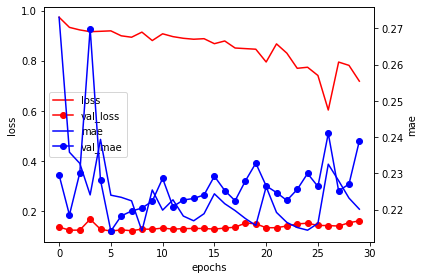

In [50]:
# посмотрим на историю обучения
r = model3.history
fig, ax1 = plt.subplots()

t = np.arange(0, len(r.history['mae']), 1)

ln1 = ax1.plot(t, r.history['loss'], color='r', label='loss')
ln2 = ax1.plot(t, r.history['val_loss'], color='r', marker='o', label='val_loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
# ax1.legend(loc=0)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ln3 = ax2.plot(t, r.history['mae'], color='b', label='mae')
ln4 = ax2.plot(t, r.history['val_mae'], color='b', marker='o', label='val_mae')
ax2.set_ylabel('mae')  # we already handled the x-label with ax1
# ax2.legend(loc=0)

lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend(loc='lower right')
plt.show()

In [51]:
# Делаем предсказание и приводим его к начальному виду
pred3 = model3.predict([np.asarray(X), sequences_pad])
predUnscaled3 = yScaler.inverse_transform(pred3).flatten()

# Среднее значение ошибки 
delta3 = predUnscaled3 - np.asarray(y)
absDelta3 = abs(delta3)
print(sum(absDelta3) / len(absDelta3))

n = 10
for i in range(n):
  print('Реальное значение - ',np.asarray(y)[i], " Предсказанное значение - ", predUnscaled3[i], " Разница - ", abs(np.asarray(y)[i]-predUnscaled3[i]))

26724.22916025392
Реальное значение -  40000.0  Предсказанное значение -  35208.66  Разница -  4791.33984375
Реальное значение -  40000.0  Предсказанное значение -  56221.387  Разница -  16221.38671875
Реальное значение -  300000.0  Предсказанное значение -  309599.03  Разница -  9599.03125
Реальное значение -  180000.0  Предсказанное значение -  154209.77  Разница -  25790.234375
Реальное значение -  40000.0  Предсказанное значение -  55616.855  Разница -  15616.85546875
Реальное значение -  200000.0  Предсказанное значение -  224811.33  Разница -  24811.328125
Реальное значение -  120000.0  Предсказанное значение -  109739.78  Разница -  10260.21875
Реальное значение -  50000.0  Предсказанное значение -  37308.94  Разница -  12691.05859375
Реальное значение -  60000.0  Предсказанное значение -  82855.48  Разница -  22855.4765625
Реальное значение -  70000.0  Предсказанное значение -  70258.72  Разница -  258.71875


# Попробуем построить модель на всех текстовых записях

In [52]:
#  оставим поля: Пол, возраст	Ищет работу на должность:	Город	Занятость	График	Опыт (двойное нажатие для полной версии)	Последенее/нынешнее место работы	Последеняя/нынешняя должность	Образование и ВУЗ
fixed_df_new = fixed_df[['Пол, возраст',	'Ищет работу на должность:',	'Город',	'Занятость',	'График',	'Опыт (двойное нажатие для полной версии)',	'Последенее/нынешнее место работы',	'Последеняя/нынешняя должность',	'Образование и ВУЗ']]
fixed_df_new.head()

,"Пол, возраст",Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ
0,"Мужчина , 29 лет , родился 16 мая 1989",Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...
1,"Мужчина , 38 лет , родился 25 мая 1980",Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...
2,"Мужчина , 35 лет , родился 14 июня 1983",DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...
3,"Мужчина , 33 года , родился 2 августа 1985",Руководитель IT отдела,"Москва , м. Щукинская , не готов к переезду ,...","частичная занятость, полная занятость","удаленная работа, полный день",Опыт работы 15 лет 10 месяцев Руководитель IT...,"""Ай-Теко"", ведущий российский системный интегр...",Старший системный администратор,Руководитель IT отдела 180 000 руб. Информацио...
4,"Мужчина , 22 года , родился 1 сентября 1996",Junior Developer,"Москва , м. Юго-Западная , не готов к переезд...","стажировка, частичная занятость, проектная работа","гибкий график, удаленная работа",Опыт работы 1 год 1 месяц Junior Developer 40...,R-Style SoftLab,Менеджер IT-проектов,Junior Developer 40 000 руб. Информационные те...


In [53]:
texts = []
for i in range(fixed_df_new.shape[0]):
  texts.append(' '.join(fixed_df_new.iloc[i,:].astype('str').values.tolist()))

texts[:2]

['Мужчина ,  29 лет , родился 16 мая 1989 Специалист по поддержке чата(support team) домашний агент Новороссийск , готов к переезду (Анапа, Геленджик) , не готов к командировкам полная занятость полный день Опыт работы 3 года 9 месяцев  Специалист по поддержке чата(support team) домашний агент 40 000 руб. Информационные технологии, интернет, телеком Системный администратор Сотовые, Беспроводные технологии Телекоммуникации Занятость: полная занятость График работы: полный день Опыт работы 3 года 9 месяцев Май 2012 — Январь  2016 3 года 9 месяцев ООО "Гольфстрим" Республика Башкортостан Строительство, недвижимость, эксплуатация, проектирование ... Строительство жилищное Управление и эксплуатация недвижимости Генеральный директор Руководство, отладка деловых связей, заключение договоров, развитие организации Ключевые навыки Теперь резюме открыто всему интернету — изменить можно в настройках видимости. Заключение договоров Деловое общение Деловая коммуникация Пользователь ПК Ведение перего

In [54]:
maxlen = 4000 

tokenizer = Tokenizer(num_words=maxlen, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(texts)         
items = list(tokenizer.word_index.items())
items[:2]

[('unknown', 118406), ('и', 2)]

In [55]:
sequences = tokenizer.texts_to_sequences(texts)
sequences[:2]

[[139,
  843,
  20,
  137,
  736,
  916,
  1138,
  57,
  4,
  1168,
  118406,
  1423,
  1062,
  118406,
  3782,
  118406,
  43,
  18,
  110,
  118406,
  118406,
  44,
  43,
  18,
  107,
  59,
  28,
  63,
  65,
  21,
  7,
  23,
  19,
  105,
  8,
  57,
  4,
  1168,
  118406,
  1423,
  1062,
  118406,
  3782,
  863,
  225,
  246,
  33,
  25,
  13,
  205,
  120,
  100,
  118406,
  118406,
  25,
  211,
  28,
  59,
  28,
  68,
  7,
  63,
  65,
  21,
  7,
  23,
  19,
  105,
  8,
  115,
  80,
  84,
  60,
  23,
  19,
  105,
  8,
  29,
  118406,
  1005,
  118406,
  172,
  395,
  241,
  151,
  172,
  1332,
  52,
  2,
  241,
  706,
  1768,
  312,
  217,
  1789,
  2173,
  3626,
  330,
  188,
  237,
  126,
  290,
  191,
  331,
  326,
  333,
  318,
  329,
  338,
  305,
  3,
  334,
  332,
  330,
  188,
  3258,
  619,
  1249,
  1755,
  802,
  163,
  64,
  298,
  52,
  559,
  1249,
  1253,
  138,
  188,
  2260,
  718,
  2204,
  2185,
  122,
  1499,
  2668,
  2152,
  310,
  494,
  14,
  3,
  590,
  340,


In [56]:
# преобразуем в one hot encoding формат
xTrainRez01 = tokenizer.sequences_to_matrix(sequences) 
print(xTrainRez01.shape)                                      
print(xTrainRez01[0][0:100])    

(61994, 4000)
[0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1.
 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


Epoch 1/50
2500/2500 [==============================] - 7s 3ms/step - loss: 1.0187 - mae: 0.2157 - val_loss: 0.0924 - val_mae: 0.1922
Epoch 2/50
2500/2500 [==============================] - 6s 3ms/step - loss: 0.9868 - mae: 0.1986 - val_loss: 0.0899 - val_mae: 0.1930
Epoch 3/50
2500/2500 [==============================] - 6s 3ms/step - loss: 0.9717 - mae: 0.1830 - val_loss: 0.1233 - val_mae: 0.1944
Epoch 4/50
2500/2500 [==============================] - 6s 3ms/step - loss: 0.9887 - mae: 0.1798 - val_loss: 0.0809 - val_mae: 0.1786
Epoch 5/50
2500/2500 [==============================] - 6s 3ms/step - loss: 0.7242 - mae: 0.1739 - val_loss: 0.0819 - val_mae: 0.1704
Epoch 6/50
2500/2500 [==============================] - 7s 3ms/step - loss: 0.7574 - mae: 0.1697 - val_loss: 0.0732 - val_mae: 0.1662
Epoch 7/50
2500/2500 [==============================] - 7s 3ms/step - loss: 0.4930 - mae: 0.1556 - val_loss: 0.0746 - val_mae: 0.1728
Epoch 8/50
2500/2500 [==============================] - 6s 3ms

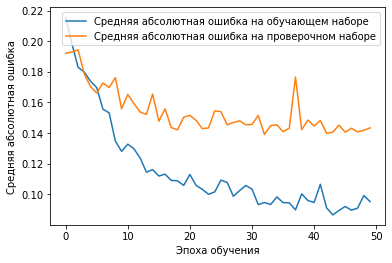

In [57]:
modelTRez = Sequential()
modelTRez.add(Dense(700, activation='relu',input_dim=(xTrainRez01.shape[1])))
modelTRez.add(Dense(500, activation='relu'))
modelTRez.add(Dropout(0.3))
modelTRez.add(Dense(1, activation='linear'))
 
modelTRez.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=['mae'])
 
history = modelTRez.fit(xTrainRez01[:50000], 
                    yTrainScaled[:50000], 
                    batch_size=20,
                    epochs=50, 
                    validation_data=(xTrainRez01[50000:], yTrainScaled[50000:]),
                    verbose=1, shuffle=True)
 
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

# Объединим все модели в одну

In [64]:
# первый вход для one hot encoding
input_1 = Input(shape=(X.shape[1],))
x1 = BatchNormalization()(input_1)
x1 = Dense(56, activation='relu', name='dense_1.1')(x1)
x1 = Dense(128, activation='relu', name='dense_1.2')(x1)
x1 = Dropout(0.3)(x1)
x1 = Dense(256, activation='relu', name='dense_1.3')(x1)

# output_1 = Dense(1, activation='linear', name='output_1')(x1)

# добавим сетку по Word2Vec

# первый вход для one hot encoding
input_2 = Input(shape=(len(sequences_pad[0]),))

embedding_layer = Embedding(len(wvec.wv.vocab)+1,
                            wvec.wv.vector_size,
                            input_length=seq_len,
                            weights=[embed_matrix],
                            trainable=True
                            )(input_2)

x2 = SpatialDropout1D(0.2)(embedding_layer)
x2 = Dense(128, activation='relu', name='dense_2.1')(x2)
x2 = Dense(96, activation='relu', name='dense_2.2')(x2)
x2 = Dropout(0.2)(x2)
x2 = Flatten()(x2)

x3 = Conv1D(96, 5, padding='same', activation='relu', name='conv_1.1')(embedding_layer)
x3 = Conv1D(128, 3, padding='same', activation='relu', name='conv_1.2')(x3)
x3 = Conv1D(156, 1, padding='same', activation='relu', name='conv_1.3')(x3)
x3 = MaxPool1D(pool_size=10, strides=2, name='mpool_1.1', padding='same')(x3)

x4 = Conv1D(72, 7, padding='same', activation='relu', name='conv_2.1')(embedding_layer)
x4 = Conv1D(96, 5, padding='same', activation='relu', name='conv_2.2')(x4)
x4 = Conv1D(128, 3, padding='same', activation='relu', name='conv_2.3')(x4)
x4 = MaxPool1D(pool_size=10, strides=2, name='mpool_2.1',padding='same')(x4)

x5 = Concatenate()([x3, x4])
x5 = MaxPool1D(pool_size=10, strides=10, name='mpool_3.1', padding='same')(x5)
x5 = Flatten(name='flatten_1.1')(x5)
x5 = Dense(x5.shape[1], activation='relu', name='dense_2.3')(x5)
# x5 = Dense(x5.shape[1]/10, activation='relu', name='dense_2.4')(x5)
x5 = Dropout(0.2)(x5)
x5 = Dense(x5.shape[1]/2, activation='relu', name='dense_2.5')(x5)


x6 = Concatenate()([x2, x5])


# третья модель
input_3 = Input(shape=(xTrainRez01.shape[1],))
x7 = BatchNormalization()(input_3)
x7 = Dense(128, activation='relu', name='dense_3.1')(x7)
x7 = Dense(500, activation='relu', name='dense_3.2')(x7)
x7 = Dropout(0.1)(x7)
x7 = Dense(64, activation='relu', name='dense_3.3')(x7)
# x7 = Dropout(0.1)(x7)


x = Concatenate()([x6, x7])

output = Dense(1, activation='linear', name='output_2')(x)

model4 = Model([input_1, input_2, input_3], output)

model4.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 6, 100)       370800      input_12[0][0]                   
__________________________________________________________________________________________________
conv_1.1 (Conv1D)               (None, 6, 96)        48096       embedding_4[0][0]                
__________________________________________________________________________________________________
conv_2.1 (Conv1D)               (None, 6, 72)        50472       embedding_4[0][0]                
______________________________________________________________________________________

Epoch 1/50
218/218 [==============================] - 4s 16ms/step - loss: 0.9248 - mae: 0.2205 - val_loss: 0.1156 - val_mae: 0.2276
Epoch 2/50
218/218 [==============================] - 3s 15ms/step - loss: 0.8700 - mae: 0.1780 - val_loss: 0.0886 - val_mae: 0.1837
Epoch 3/50
218/218 [==============================] - 3s 15ms/step - loss: 0.8275 - mae: 0.1620 - val_loss: 0.0782 - val_mae: 0.1709
Epoch 4/50
218/218 [==============================] - 3s 15ms/step - loss: 0.9072 - mae: 0.1653 - val_loss: 0.0868 - val_mae: 0.1952
Epoch 5/50
218/218 [==============================] - 3s 14ms/step - loss: 0.8437 - mae: 0.1468 - val_loss: 0.0785 - val_mae: 0.1668
Epoch 6/50
218/218 [==============================] - 3s 15ms/step - loss: 0.7268 - mae: 0.1374 - val_loss: 0.0883 - val_mae: 0.1742
Epoch 7/50
218/218 [==============================] - 3s 15ms/step - loss: 0.4148 - mae: 0.1274 - val_loss: 0.0706 - val_mae: 0.1586
Epoch 8/50
218/218 [==============================] - 3s 15ms/step - 

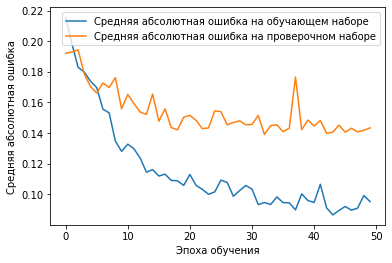

In [65]:
model4.compile(optimizer=Adam(1e-3),
              loss='mse',
              metrics=['mae'])

model4.fit([np.asarray(X), sequences_pad, xTrainRez01],
          yTrainScaled,
          epochs=50,
          validation_split=0.1,
          batch_size=256,
          verbose=1,
          shuffle=True)


plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [66]:
# Делаем предсказание и приводим его к начальному виду
pred4 = model4.predict([np.asarray(X), sequences_pad, xTrainRez01])
predUnscaled4 = yScaler.inverse_transform(pred4).flatten()

# Среднее значение ошибки 
delta4 = predUnscaled4 - np.asarray(y)
absDelta4 = abs(delta4)
print(sum(absDelta4) / len(absDelta4), '\n')

n = 10
for i in range(n):
  print('Реальное значение - ',np.asarray(y)[i], " Предсказанное значение - ", predUnscaled4[i], " Разница - ", abs(np.asarray(y)[i]-predUnscaled4[i]))

7143.120972332 

Реальное значение -  40000.0  Предсказанное значение -  34681.555  Разница -  5318.4453125
Реальное значение -  40000.0  Предсказанное значение -  43035.4  Разница -  3035.3984375
Реальное значение -  300000.0  Предсказанное значение -  318886.62  Разница -  18886.625
Реальное значение -  180000.0  Предсказанное значение -  186605.8  Разница -  6605.796875
Реальное значение -  40000.0  Предсказанное значение -  33857.17  Разница -  6142.828125
Реальное значение -  200000.0  Предсказанное значение -  203959.48  Разница -  3959.484375
Реальное значение -  120000.0  Предсказанное значение -  124133.086  Разница -  4133.0859375
Реальное значение -  50000.0  Предсказанное значение -  49163.473  Разница -  836.52734375
Реальное значение -  60000.0  Предсказанное значение -  62065.96  Разница -  2065.9609375
Реальное значение -  70000.0  Предсказанное значение -  67421.29  Разница -  2578.7109375
